In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from libs.tools import *
from libs.network import *
import torch
from geopy.distance import geodesic
from scipy import spatial
import copy

/home/ids/yukliu/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Loading embedding data

In [ ]:
model = torch.load(f'/home/ids/yukliu/OpenTest/checkpoints/Triplet_emb_{embed_dim}_m_2_bs_{bs}_{suffix}.sav')

In [3]:
class ANN2(nn.Module):
    def __init__(self, in_feats, out_dim, hiddens=[64, 32]):
        super().__init__()
        self.name = "ANN"
        th.set_default_dtype(th.float32)
        assert len(hiddens) > 1
        list_FC_layers = [nn.Linear(in_feats, hiddens[0]), nn.ReLU()]
        n_hiddens = len(hiddens)
        for l in range(n_hiddens - 1):
            list_FC_layers.append(nn.Linear(hiddens[l], hiddens[l+1]))
            list_FC_layers.append(nn.ReLU())
            list_FC_layers.append(nn.BatchNorm1d(hiddens[l+1]))
        list_FC_layers.append(nn.Linear(hiddens[n_hiddens - 1], out_dim))
        # list_FC_layers.append(nn.BatchNorm1d(out_dim))
        self.model = nn.Sequential(*list_FC_layers)

    def forward(self, X):
        # return th.exp(self.model.forward(X))
        return self.model.forward(X.to(dtype=th.float32))
    
    def get_embedding(self, x):
        return self.forward(x)

In [4]:
bs = 256
embed_dim_ls  = [2, 16, 64, 128]
suffix = 'OpenDataTest_OfflineMining'
test_embed_ls = []
train_embed_ls = []
model_ls = []
dim_1 = 1024
start = 512

for embed_dim in embed_dim_ls:

    # test_tmp = np.load(f'./data/test_embedding_{embed_dim}_m_2_bs_{bs}_{suffix}.npy')
    # train_tmp = np.load(f'./data/train_embedding_{embed_dim}_m_2_bs_{bs}_{suffix}.npy')

    # test_embed_ls.append(test_tmp)
    # train_embed_ls.append(train_tmp)

    hiddens = [int(start / (2 ** i)) for i in range(100) if start / (2 ** i) >= embed_dim]

    embedding_net = ANN2(dim_1, embed_dim, hiddens=hiddens)
    triplet_net_tmp = TripletNet(embedding_net)
    triplet_net_tmp.load_state_dict(torch.load(f'/home/ids/yukliu/OpenTest/checkpoints/Triplet_emb_{embed_dim}_m_2_bs_{bs}_{suffix}.sav'))
    model_ls.append(triplet_net_tmp)

# Load raw data

In [5]:
meta_data = pd.read_csv('./data/dichasus.csv')
# meta_data = pd.read_csv('./data/Opendata_3.csv')
csi_cols = [col for col in meta_data.columns if col not in ['Unnamed: 0', 'time', 'x', 'y']]
csi_data = meta_data[csi_cols].values
locations = meta_data[['x', 'y']].values

# Channel Charting with Model

In [6]:
cc_ls = []
csi_tensor = torch.FloatTensor(csi_data)

for model in model_ls:

    cc_tmp = model.get_embedding(csi_tensor)
    cc_arr_tmp = cc_tmp.detach().numpy()
    cc_ls.append(cc_arr_tmp)

In [7]:
import sys

## distance in embedding space

In [8]:
from channel_charting_tools import *

In [10]:
tmp = {'d': d,
       'c': c}

In [15]:
np.save('./data/triplet_time_dist', tmp, allow_pickle=True)

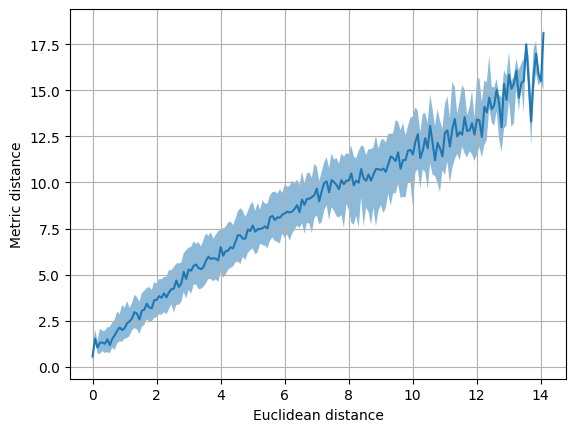

In [9]:
d, c = embedding_distance(cc_ls[0], locations)
draw_ci_plot(d, c)

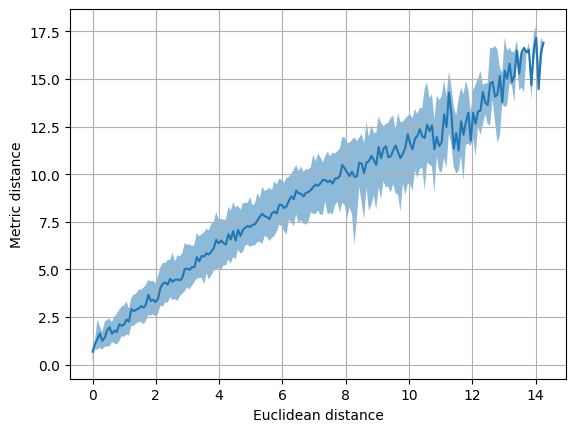

In [17]:
d, c = embedding_distance(cc_ls[0], locations)
draw_ci_plot(d, c)

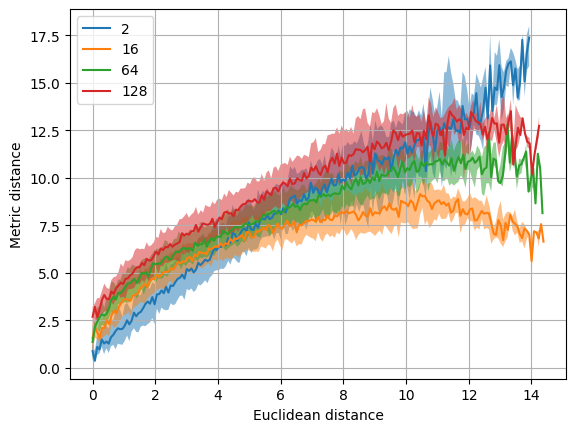

In [22]:
for cc, dim in zip(cc_ls, embed_dim_ls):
    d, c = embedding_distance(cc, locations)
    draw_ci_plot(d, c, label=dim)

plt.grid()
plt.legend()
# plt.savefig('./result/embed_distance_dimension_compare.pdf')

# Evaluation with KNN 

In [38]:
from offline_mining_tools import localisation_cc

In [39]:
err_distance = np.load('./data/dist_err_distance_opendata.npy')
err_autogluon = np.load('../data/dist_err_autogluon_OpenData_Autogluon.npy')
err_bm = np.load('./data/opendata_benchmark.npy')

In [ ]:
err_ls = []

for cc, dim in zip(cc_ls, embed_dim_ls):
    err_tmp = localisation_cc(cc, locations, n_neigh=5)
    err_ls.append(err_tmp, label=dim)

plt.legend()

In [28]:
import matplotlib

In [29]:
colors = matplotlib.cm.tab20(range(20))

In [30]:
for err in err_ls:
    cdf_plot(err)

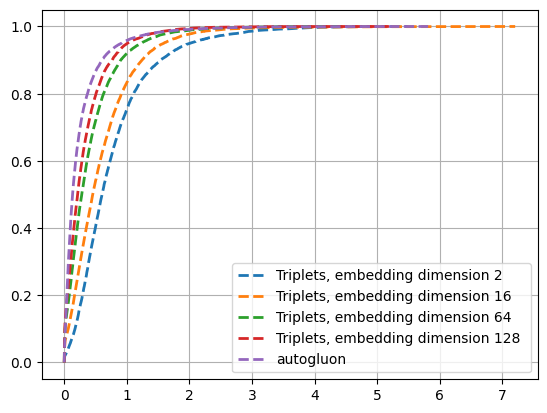

In [51]:
cdf_plot(err_bm)
for err in err_ls:
    cdf_plot(err)

# cdf_plot(err_distance)
cdf_plot(err_autogluon)

plt.grid()
plt.legend([f'Triplets, embedding dimension {i} ' for i in [2,*embed_dim_ls]] + ['autogluon'])
plt.savefig('./result/embedding_compare.pdf')
# plt.legend([*embed_dim_ls, 'Triplets By Distance', 'Benchmark', 'Autogluon'])
# plt.legend(['Triplets By distance', 'Triplets By time', 'Autogluon'])

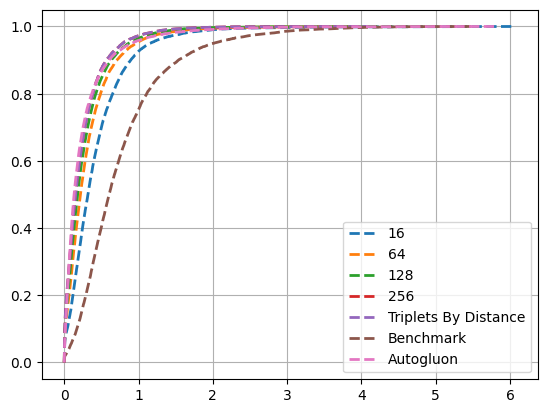

In [31]:
for err in err_ls:
    cdf_plot(err)

# cdf_plot(err)
# cdf_plot(err_bm)
# cdf_plot(err_autogluon)

plt.grid()
plt.legend([*embed_dim_ls, 'Triplets By Distance', 'Benchmark', 'Autogluon'])
# plt.legend(['Triplets By distance', 'Triplets By time', 'Autogluon'])